# Data analysis of the ACE2005 dataset
In this notebook I am doing an analysis of the Ace 2005 dataset.
This will include transformations, graphs and all other material related to the master thesis.

## Importing the training data
I will begin by importing only the training data. This is the dataset I will do my analysis on, consequently not giving me any foresight into
the testing data.

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import pandas as pd
import os
import sys
from typing import Sequence, Dict, Any, Tuple, get_args
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

In [3]:
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), ".."))

In [4]:
from certainty import EventSentence, load_file, convert_events, EventType, bootstrap_metrics

In [5]:
ace_train = load_file("en_train.json")
ace_dev = load_file("en_dev.json")
ace_test = load_file("en_test.json")

In [6]:
[x for x in ace_train if len(x['events']) > 0 and len(x["events"][0]["arguments"]) > 10][0]

{'sent_id': 'nw/APW_ENG_20030513.0139/006',
 'text': 'A U.S. military official in Seoul , speaking on condition of anonymity , said Tuesday North Korea is believed to have exported US$ 580 million worth of missiles to Iran , Pakistan , Libya , Syria , Egypt , Yemen and the United Arab Emirates in 2001',
 'events': [{'event_type': 'Transfer-Ownership',
   'event_polarity': 'Positive',
   'event_genericity': 'Specific',
   'event_modality': 'Other',
   'trigger': [['exported'], ['118:126']],
   'arguments': [[['North Korea'], ['86:97'], 'Seller'],
    [['US$ 580 million'], ['127:142'], 'Price'],
    [['missiles'], ['152:160'], 'Artifact'],
    [['Iran'], ['164:168'], 'Buyer'],
    [['Pakistan'], ['171:179'], 'Buyer'],
    [['Libya'], ['182:187'], 'Buyer'],
    [['Syria'], ['190:195'], 'Buyer'],
    [['Egypt'], ['198:203'], 'Buyer'],
    [['Yemen'], ['206:211'], 'Buyer'],
    [['the United Arab Emirates'], ['216:240'], 'Buyer'],
    [['2001'], ['244:248'], 'Time-Within']]}]}

In [7]:
train_df = pd.DataFrame(ace_train).drop_duplicates('text').drop_duplicates('events')
dev_df = pd.DataFrame(ace_dev).drop_duplicates('text').drop_duplicates('events')
test_df = pd.DataFrame(ace_test).drop_duplicates('text').drop_duplicates('events')

In [8]:
train_df.describe()

,sent_id,text,events
count,3246,3246,3246
unique,3246,3246,3246
top,bc/CNN_IP_20030329.1600.02/001,It was in northern Iraq today that an eight ar...,"[{'event_type': 'Attack', 'event_polarity': 'P..."
freq,1,1,1


In [9]:
test_df.describe()

,sent_id,text,events
count,293,293,293
unique,293,293,293
top,nw/APW_ENG_20030322.0119/001,U.S. and British troops were moving on the str...,"[{'event_type': 'Transport', 'event_polarity':..."
freq,1,1,1


## General datastructure
We see that the general structure of the data is as follows:
- Each datapoint in the collection is a mapping of three fields, all relating to a single sentence.
- **Sent_id** is an identifier for this particular sentence
- **Text** is the raw non-processed text
- **Events** is a collection of events identified for that particular sentence, also taking the role as the gold standard "label" of the datapoint.

### Event
The event collection is a list of identified events. Each event has  some important fields:
- **Event_type** the type of event taken from the predefined ace ontology
- **Event_polarity** the sentiment of the event (positive/negative)
- **Event_genericity** whether the event is a *generic* statement, or about something *specific*
- **Event_modality** Whether the event is asserted or not. This is the most relevant field to my thesis.



### Flattening the structure
Because the aim is to identify the modality of each event, the sentence is not the only input data we need to account for.

Later on, the amount of information supplied to each classifier may include all the information about the event, or none of it (for example in a joint model). The effect that the event data has on the target classifier is interesting in and of itself.

In [10]:
train_events: Sequence[EventSentence] = list(convert_events(train_df.to_dict('records')))
dev_events: Sequence[EventSentence] = list(convert_events(dev_df.to_dict('records')))
test_events: Sequence[EventSentence] = list(convert_events(test_df.to_dict('records')))

In [11]:
print(len(train_events))
print(len(dev_events))
print(len(test_events))

4261
496
424


In [12]:
train_events[0]

{'sent_id': 'bc/CNN_IP_20030329.1600.02/001',
 'text': 'It was in northern Iraq today that an eight artillery round hit the site occupied by Kurdish fighters near Chamchamal',
 'type': 'Attack',
 'modality': 'Asserted',
 'label': 1,
 'polarity': 'Positive',
 'genericity': 'Specific',
 'trigger': 'hit'}

# Exploring the distributions
First, we will explore the distribution of the modality.

Second, we will explore the distribution of the types of event.

Third, we will explore secondary fields, such as the genericity and polarity.

Lastly, we may look at a few of the fields in relation to each other.


In [13]:
# Preparing the data for plotting with sns
category_order = ['Asserted', 'Other']
train_events_df: pd.DataFrame = pd.DataFrame(train_events)
train_events_df['modality'] = pd.Categorical(train_events_df['modality'], categories=category_order, ordered=True)
dev_events_df: pd.DataFrame = pd.DataFrame(dev_events)
dev_events_df['modality'] = pd.Categorical(dev_events_df['modality'], categories=category_order, ordered=True)
test_events_df: pd.DataFrame = pd.DataFrame(test_events)
test_events_df['modality'] = pd.Categorical(test_events_df['modality'], categories=category_order, ordered=True)

In [14]:
train_events_df.head()

,sent_id,text,type,modality,label,polarity,genericity,trigger
0,bc/CNN_IP_20030329.1600.02/001,It was in northern Iraq today that an eight ar...,Attack,Asserted,1,Positive,Specific,hit
1,bc/CNN_IP_20030329.1600.02/002,A day ago it was controlled by Iraqi troops an...,Transport,Asserted,1,Positive,Specific,drive
2,bc/CNN_IP_20030329.1600.02/003,That 's because coalition fighter jets pummele...,Attack,Asserted,1,Positive,Specific,pummeled
3,bc/CNN_IP_20030329.1600.02/003,That 's because coalition fighter jets pummele...,Transport,Asserted,1,Positive,Specific,retreat
4,bc/CNN_IP_20030329.1600.02/004,I 'm glad to see them go this one says,Transport,Asserted,1,Positive,Specific,go


In [15]:
pd.concat([train_events_df, dev_events_df, test_events_df])["trigger"].describe()

count     5181
unique    1246
top        war
freq       323
Name: trigger, dtype: object

In [16]:
pd.concat([train_events_df, dev_events_df, test_events_df])["type"].describe()

count       5181
unique        33
top       Attack
freq        1509
Name: type, dtype: object

In [17]:
sns.set_theme()

## Modality
We see from the histogram, that there is a tendency towards asserted statements.
In fact we see from the value_counts that there is an approximate 3 to 1 ratio of asserted to non-asserted events.

In [18]:
tedf_vc = train_events_df["modality"].value_counts()
tedf_vc

Asserted    3216
Other       1045
Name: modality, dtype: int64

In [19]:
tedf_vc['Asserted']/tedf_vc['Other']

3.077511961722488

In [20]:

dedf_vc = dev_events_df["modality"].value_counts()
dedf_vc

Asserted    356
Other       140
Name: modality, dtype: int64

In [21]:
dedf_vc['Asserted']/dedf_vc['Other']

2.5428571428571427

In [22]:

teedf_vc = test_events_df["modality"].value_counts()
teedf_vc

Asserted    308
Other       116
Name: modality, dtype: int64

In [23]:
teedf_vc['Asserted']/teedf_vc['Other']

2.6551724137931036

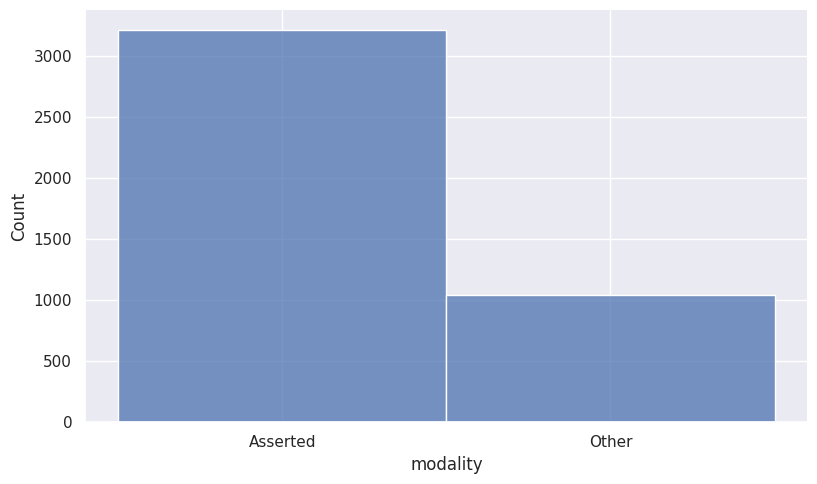

In [24]:
ds = sns.displot(train_events_df, x="modality", aspect=5/3)
fig = ds.fig
fig.savefig("../figures/ace_train_modality_distribution.png") 

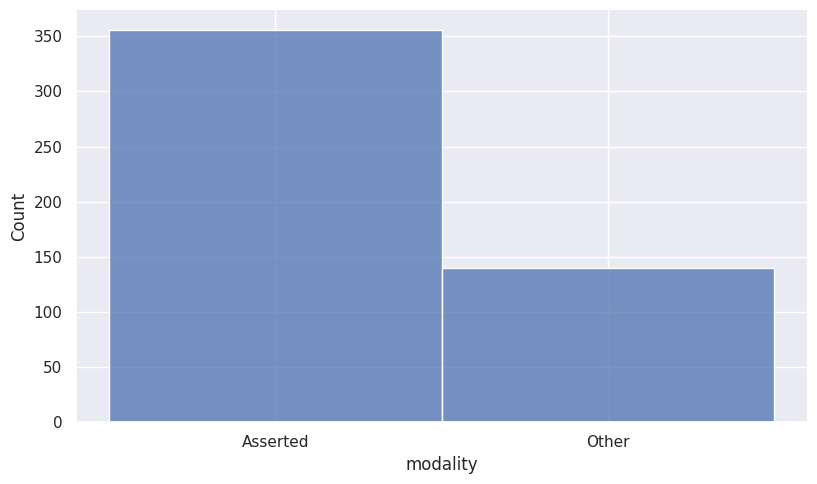

In [25]:
ds = sns.displot(dev_events_df, x="modality", aspect=5/3)
fig = ds.fig
fig.savefig("../figures/ace_dev_modality_distribution.png") 

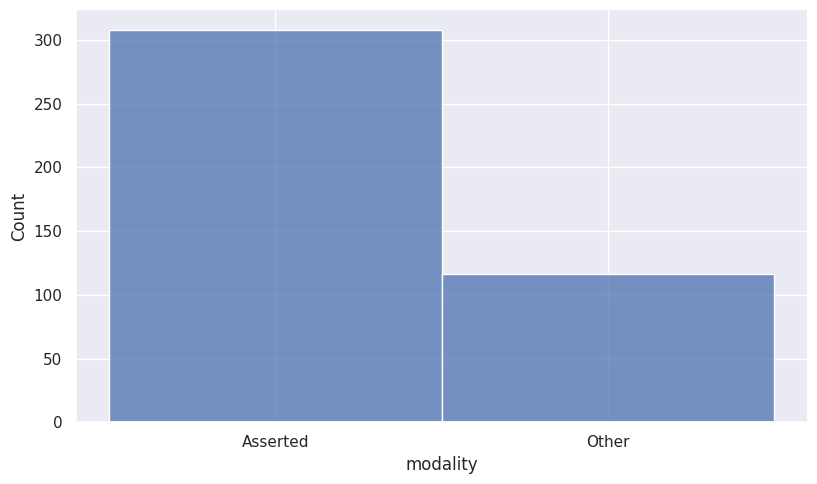

In [26]:
ds = sns.displot(test_events_df, x="modality", aspect=5/3)
fig = ds.fig
fig.savefig("../figures/ace_test_modality_distribution.png") 

## Types

In [27]:
events_df = pd.concat([train_events_df, dev_events_df, test_events_df])

In [28]:
len(events_df["type"].unique())

33

We see that there are 33 types of events.
The most common event is the Attack event, followed by transport and die.

In [29]:
events_df["type"].value_counts()

Attack                1509
Transport              717
Die                    561
Meet                   278
End-Position           209
Transfer-Money         189
Elect                  166
Injure                 142
Transfer-Ownership     125
Phone-Write            123
Charge-Indict          106
Start-Position         106
Sentence                96
Trial-Hearing           96
Arrest-Jail             88
Demonstrate             80
Marry                   77
Sue                     71
Convict                 70
Be-Born                 47
Start-Org               47
Appeal                  43
Release-Parole          42
Declare-Bankruptcy      41
End-Org                 37
Fine                    28
Divorce                 27
Execute                 21
Merge-Org               14
Nominate                12
Acquit                   6
Extradite                5
Pardon                   2
Name: type, dtype: int64

The least common events are Pardon and Acquit which could be considered fairly similar.
It is obvious from the data that this is sampled from a news source. This fact explains the amount of asserted statements.


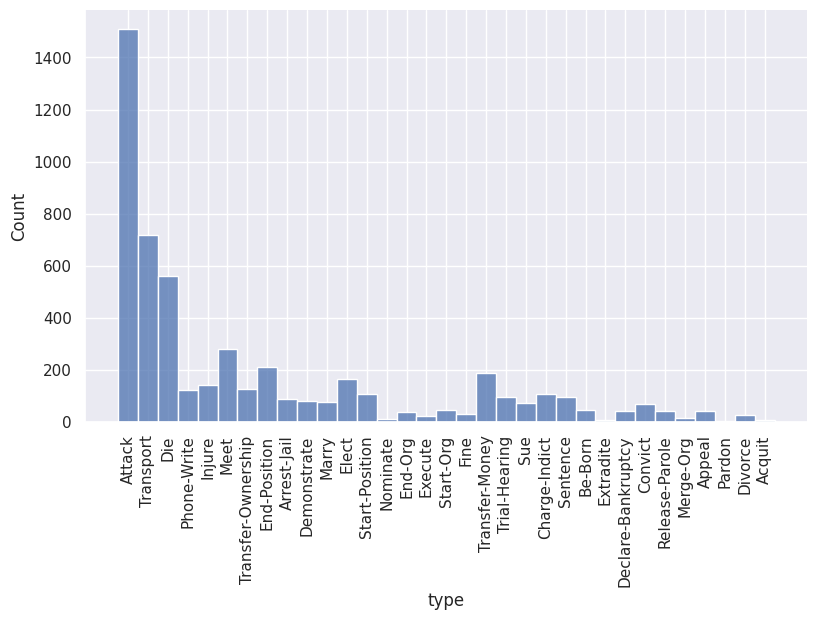

In [30]:
dist = sns.displot(events_df, x="type", aspect=5/3)
dist.set_xticklabels(rotation=90)

fig = dist.fig
fig.savefig("../figures/ace_event_type_distribution.png") 

## Genercitiy and polarity

In [31]:
events_df["genericity"].value_counts()


Specific    4031
Generic     1150
Name: genericity, dtype: int64

We see that specific events has a 3 to 1 ratio with the the generic events. This may hint at a correlation between specific and asserted events.


In [32]:
events_df["polarity"].value_counts()

Positive    4995
Negative     186
Name: polarity, dtype: int64

We see that the overwhelming majority of events are positive. What is meant by positive in this space is difficult to tell, and we have to consult the original ace paper to find out.

In [33]:
event = events_df[events_df['polarity'] == 'Negative'].iloc[0]

In [34]:
event['text']

"Now , Iraq 's minister of information today said that the coalition did not have control of the airport , that this was some sort of contrived video from the first day , and that , in fact , hundreds of coalition soldiers had been killed , and their graves were now at the airport"

In [35]:
event['trigger']

'control'

In [36]:
event['type']

'Transfer-Ownership'

In [37]:
event = events_df[events_df['genericity'] == 'Generic'].head()

In [38]:
event

,sent_id,text,type,modality,label,polarity,genericity,trigger
8,bc/CNN_IP_20030329.1600.02/006,"Although the Iraqis retreated from this area ,...",Die,Other,0,Positive,Generic,casualties
16,bc/CNN_CF_20030305.1900.06-1/002,"I think it 's unwise , it 's unjust , it 's un...",Attack,Other,0,Positive,Generic,it
17,bc/CNN_CF_20030305.1900.06-1/004,"Time now for "" Fireback , "" where our wacky an...",Phone-Write,Asserted,1,Positive,Generic,right
44,bc/CNN_IP_20030408.1600.04/012,It is an elementary fact of life during wartim...,Attack,Asserted,1,Positive,Generic,wartime
48,bc/CNN_IP_20030408.1600.04/014,The 600 journalists embedded with American tro...,Attack,Asserted,1,Positive,Generic,fire


In [39]:
event.iloc[4]['text']

'The 600 journalists embedded with American troops in Iraq will be threatened by the same fire as the troops they are covering'

## Correlations
In this section I aim to look at the correlation of the different fields.

### Correlations without type
Since there is a large amount of types of events, it is beneficial to look at individual fields with the type.
Initially we will only look at the genericity, modality and polarity.


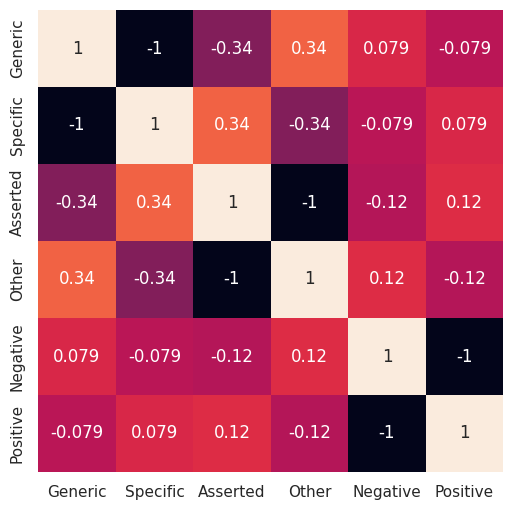

In [40]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(pd.get_dummies(events_df[["genericity", "modality", "polarity"]],  prefix='', prefix_sep='').corr(), ax=ax, annot=True, cbar=False)
fig.savefig("../figures/ace_modality_polarity_genericity_correlation.png") 

- We see that Asserted events have a correlation of .33 with Specific as expected.
- The negative polarity of the event is moderately correlated with the asserted events.

## Types in relation to assertiveness
We also whish to see whether the type of event is related to the assertiveness. I will perform a chi squared contingency test. 
The null-hypothesis of this test is that there is not relatedness with the two variables.


In [41]:
contingency_table =pd.crosstab(events_df["modality"], events_df["type"])

chi2, p, dof, expected = chi2_contingency(contingency_table) # For the ace dataset the label is a discrete binary variable.

# Print the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")


Chi-square statistic: 210.16601441508257
P-value: 4.321406454985105e-28
Degrees of freedom: 32


In [42]:
contingency_table

type,Acquit,Appeal,Arrest-Jail,Attack,Be-Born,Charge-Indict,Convict,Declare-Bankruptcy,Demonstrate,Die,...,Phone-Write,Release-Parole,Sentence,Start-Org,Start-Position,Sue,Transfer-Money,Transfer-Ownership,Transport,Trial-Hearing
modality,,,,,,,,,,,,,,,,,,,,,
Asserted,5,35,77,1092,40,91,61,24,74,473,...,99,18,68,32,74,48,128,64,513,83
Other,1,8,11,417,7,15,9,17,6,88,...,24,24,28,15,32,23,61,61,204,13


We see that the p-value is very low, and can conclude that there is evidence for a relatedness between the modality and the type of event.

To further investigate this relatedness I will plot the 

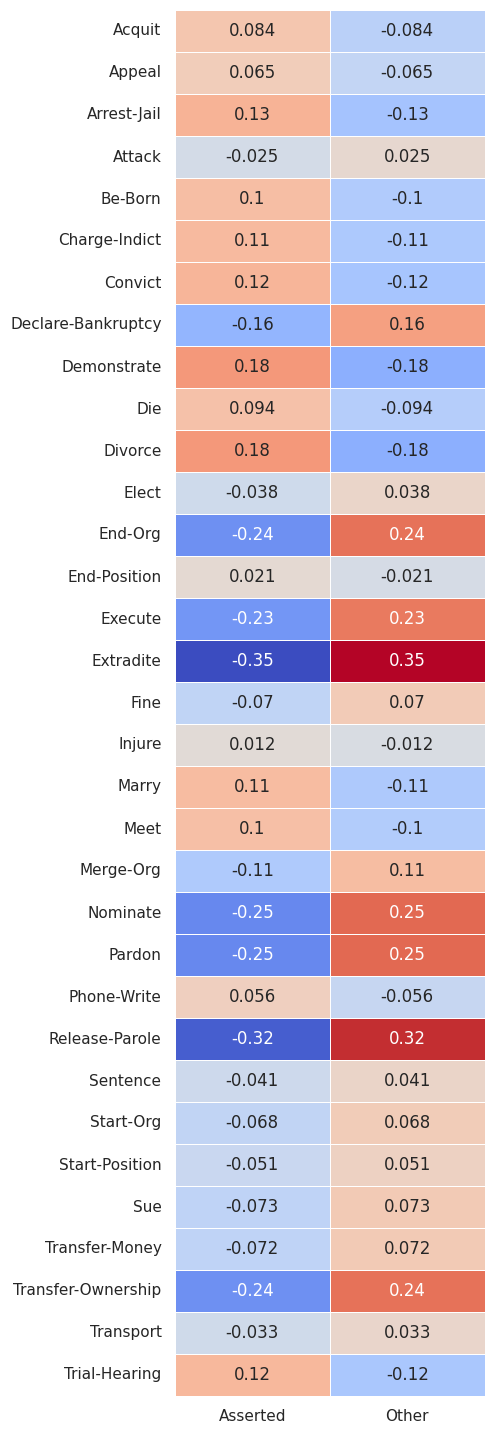

In [43]:
proportions_table = contingency_table.div(contingency_table.sum(axis=0), axis=1)
total_asserted_ratio = contingency_table.sum(axis=1) / contingency_table.values.sum()
proportional_differences = proportions_table.sub(total_asserted_ratio, axis=0)
fig, ax = plt.subplots(figsize=(4, 18))
proportional_differences = proportional_differences.T
sns.heatmap(proportional_differences, annot=True, cmap="coolwarm", center=0, linewidths=0.5, cbar=False)

#plt.xlabel('Type')
#plt.ylabel('Modality')
plt.xlabel('')
plt.ylabel('')
#plt.xticks(rotation=90)
plt.show() # For the ace dataset the label is a discrete binary variable.

fig.savefig("../figures/proportional_differences_types_modality.png", bbox_inches='tight') 

This plot needs an explanation. It is measuring the deviation per type from the mean assertiveness of all events. If a type is more assertive (or less) than the average it is shown here. This to both account for the difference in amount events per type and for the difference in amount of asserted events vs other.

We see that the most interesting type is the Release-parole type, which is more likely to not be asserted than for example Divorce, Die, and demonstrate.

What we can conclude from this is that it may be relatively easy to create a simple linear model as a baseline, and only use the type of event as independent variables.

# Triggers

# Logistic model types to modality

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.utils import resample

In [45]:
def create_model_data(events: Sequence[EventSentence]) -> Tuple[pd.DataFrame, pd.Series]:
    events_df: pd.DataFrame = pd.DataFrame(events)
    expected_columns = ['type_' + eventtype for eventtype in get_args(EventType)[1:]] # dropfirst
    X = pd.get_dummies(events_df[["type"]], drop_first=True) # Dropping first variable for interpretability. Not strictly necessary because of regularization
    
    for col in expected_columns:
        if col not in X.columns:
            X[col] = 0  # Add the missing column filled with 0s
        
    y = events_df["modality"].map({"Asserted": 1, "Other": 0})
    return (X, y)

In [46]:
random_seed: int = 245321

In [152]:
model: LogisticRegression = LogisticRegression(random_state=random_seed)
model2: LogisticRegression = LogisticRegression(random_state=random_seed, class_weight="balanced")

In [153]:
X_train, y_train = create_model_data(train_events)

In [154]:
model.fit(X_train, y_train)
model2.fit(X_train,y_train)

LogisticRegression(class_weight='balanced', random_state=245321)

In [155]:
model.coef_

array([[ 0.27916087,  0.88045692, -0.06107622,  0.52800871,  0.73992885,
         0.57135576, -0.56007034,  1.04067644,  0.6746265 ,  0.6893808 ,
        -0.14802626, -0.87242927,  0.114147  , -0.81610431, -1.02558571,
        -0.23705051, -0.00307141,  0.52166929,  0.574929  , -0.35123126,
        -0.90374195, -0.3433929 ,  0.23681015, -1.17858702, -0.23035251,
        -0.07217162, -0.19146558, -0.2264147 ,  0.2132419 , -0.70420812,
        -0.09686237,  0.67010929,  0.        ]])

In [156]:
model2.coef_

array([[ 0.28573856,  0.90840552, -0.07102666,  0.54525586,  0.75288511,
         0.58544735, -0.57616764,  1.09456295,  0.66860538,  0.7688182 ,
        -0.1587258 , -0.8850777 ,  0.10564923, -0.83481728, -1.03626219,
        -0.25484464, -0.01268418,  0.52990673,  0.57267843, -0.37412524,
        -0.91656144, -0.38446667,  0.23067795, -1.18475009, -0.24228157,
        -0.08327694, -0.20309698, -0.23831883,  0.20640532, -0.7163482 ,
        -0.10680353,  0.68071277,  0.        ]])

In [161]:
(model.predict(X_dev) == y_dev).describe()

count      496
unique       2
top       True
freq       356
Name: modality, dtype: object

In [112]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1.0, 10, 100],   # Inverse of regularization strength
    'solver': ['saga'],                # Using 'saga' to support 'l1', 'l2', and 'elasticnet'
    'max_iter': [100, 200, 500]        # Number of iterations for optimization
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 45 candidates, totalling 225 fits


/home/peder/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peder/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peder/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peder/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peder/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/peder/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: Con

In [113]:
best_model

LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   random_state=245321, solver='saga')

In [114]:
X_dev, y_dev = create_model_data(dev_events)

In [115]:
X_dev = X_dev.reindex(columns=X_train.columns, fill_value=0)

In [116]:
X_test, y_test = create_model_data(test_events)

In [117]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [131]:
# Get bootstrapped metrics in a dataframe
bootstrap_metrics_df = bootstrap_metrics(model, X_dev, y_dev)

In [132]:
bootstrap_metrics_df

,accuracy,precision,recall,f1_score
0,0.433468,0.688525,0.360000,0.472795
1,0.441532,0.695652,0.366762,0.480300
2,0.461694,0.707692,0.396552,0.508287
3,0.431452,0.692708,0.373596,0.485401
4,0.419355,0.652174,0.348837,0.454545
...,...,...,...,...
995,0.425403,0.713483,0.351801,0.471243
996,0.397177,0.672316,0.330556,0.443203
997,0.417339,0.659218,0.341040,0.449524
998,0.451613,0.739583,0.390110,0.510791


In [133]:
print(bootstrap_metrics_df.describe().loc[['mean', 'std']].to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &  precision &    recall &  f1\_score \\
\midrule
mean &  0.427208 &   0.689602 &  0.368003 &  0.479434 \\
std  &  0.021505 &   0.032760 &  0.025233 &  0.025736 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_148673/3208192097.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(bootstrap_metrics_df.describe().loc[['mean', 'std']].to_latex())


In [134]:
import numpy as np

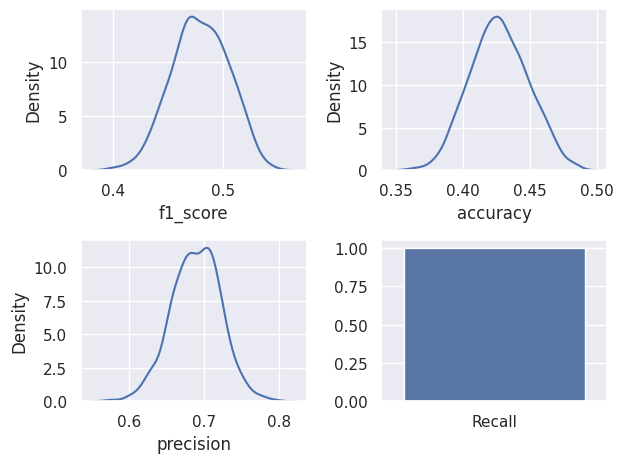

In [135]:
f, axes = plt.subplots(2, 2)
sns.kdeplot(data=bootstrap_metrics_df, x="f1_score",  ax=axes[0][0])
sns.kdeplot(data=bootstrap_metrics_df, x="accuracy",  ax=axes[0][1])
sns.kdeplot(data=bootstrap_metrics_df, x="precision",  ax=axes[1][0])
sns.barplot(x=['Recall'], y=[1], ax=axes[1][1])

plt.tight_layout()
f.savefig("../results/logistic_metrics.png", dpi=300)  # Save with high resolution


In [84]:
def plot_misclassification_chart(misclassified, dev_df):
    other_value_counts = misclassified[misclassified["True Label"]=="Other"]['Event type'].value_counts()
    asserted_value_counts = misclassified[misclassified["True Label"]=="Asserted"]['Event type'].value_counts()
    df = pd.DataFrame()
    #mis_series = (misclassified_type['Event type'].value_counts() / dev_df['type'].value_counts()).fillna(0)
    df["asserted_misclassified"] = (asserted_value_counts / dev_df[dev_df["modality"] == "Asserted"]['type'].value_counts()).fillna(0)
    df["other_misclassified"] = -(other_value_counts / dev_df[dev_df["modality"] == "Other"]['type'].value_counts()).fillna(0)
    #df["type"] = list(mis_series.index.to_series())
    # df["percent_misclassified"] =  list(mis_series)
    df["other_misclassified"] = df["other_misclassified"].fillna(0)
    df = df.sort_values(by=["other_misclassified", "asserted_misclassified"], ascending=True)
    fig, ax = plt.subplots(figsize=(10, 5))
    
    sns.barplot(y=df.index, x=df["asserted_misclassified"], color=sns.color_palette("pastel")[0], label="Asserted Misclassified", ax=ax)
    sns.barplot(y=df.index, x=df["other_misclassified"], color=sns.color_palette("pastel")[1], label="Other Misclassified", ax=ax)
    # Add labels and title
    ax.set_xlabel("Misclassification Ratio relative to whole validation set")
    ax.set_ylabel("Event Type")
    ax.set_title("Misclassification Rates by Event Type and modality")
    ax.set_xticks([-1.0, -0.5, -0.25, 0, 0.25, 0.5, 1.0])  # Adjust based on range
    ax.set_xticklabels(["1.0", "0.5", "0.25", "0", "0.25", "0.5", "1.0"])
    ax.legend()
    return fig

In [85]:
y_pred = best_model.predict(X_dev)

In [88]:
# Create DataFrame to store results
dev_df = X_dev.copy()
dev_df["True Label"] = y_dev.values
dev_df["Predicted Label"] = y_pred



In [94]:
dev_df.describe()

,type_Appeal,type_Arrest-Jail,type_Attack,type_Be-Born,type_Charge-Indict,type_Convict,type_Declare-Bankruptcy,type_Demonstrate,type_Die,type_Divorce,...,type_Start-Org,type_Start-Position,type_Sue,type_Transfer-Money,type_Transfer-Ownership,type_Transport,type_Trial-Hearing,type_Acquit,True Label,Predicted Label
count,496.0,496.000000,496.000000,496.0,496.000000,496.000000,496.000000,496.000000,496.000000,496.0,...,496.0,496.00000,496.000000,496.000000,496.000000,496.000000,496.000000,496.0,496.000000,496.0
mean,0.0,0.008065,0.356855,0.0,0.004032,0.012097,0.002016,0.018145,0.114919,0.0,...,0.0,0.02621,0.024194,0.094758,0.010081,0.125000,0.002016,0.0,0.717742,1.0
std,0.0,0.089530,0.479555,0.0,0.063436,0.109428,0.044901,0.133611,0.319247,0.0,...,0.0,0.15992,0.153805,0.293176,0.099996,0.331053,0.044901,0.0,0.450553,0.0
min,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0
25%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0
50%,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.0
75%,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.0
max,0.0,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,...,0.0,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.0


In [93]:

# Identify the event type column names (excluding 'True Label' and other non-event columns)
event_type_columns = [col for col in df.columns if col not in ["True Label", "Predicted Label", "modality"]]

# Extract Event Type (Assuming one event type per row)
dev_df["Event type"] = X_dev[event_type_columns].idxmax(axis=1)

# Filter misclassified samples
misclassified = dev_df[dev_df["True Label"] != dev_df["Predicted Label"]]



NameError: name 'df' is not defined

In [88]:

bootstrap_test_df = bootstrap_metrics(best_model, X_test, y_test)

In [90]:
import wandb
wandb.init(
    project="certainty",
    name="logistic-baseline",
    dir="..",
)
wandb.log({
    "eval/accuracy": bootstrap_test_df["accuracy"].mean(),
    "eval/precision": bootstrap_test_df["precision"].mean(),
    "eval/recall": bootstrap_test_df["recall"].mean(),
    "eval/f1": bootstrap_test_df["f1_score"].mean()
})
wandb.finish()

eval/accuracy,▁
eval/f1,▁
eval/precision,▁
eval/recall,▁
eval/accuracy,0.72628
eval/f1,0.84125
eval/precision,0.72628
eval/recall,1
